In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
import chainerx

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from comet_ml import Experiment
def log_cometml(exp, _log_report='LogReport'):
    @training.make_extension(trigger=(1, 'epoch'))
    def _log_exp(trainer):
        log_report = trainer.get_extension(_log_report)
        lastest_log = log_report.log[-1]
        n_epoch = lastest_log.pop('epoch')
        exp.log_metrics(lastest_log, step=n_epoch)
    return _log_exp

In [3]:
# define Model
class CNN(chainer.Chain):
    
    def __init__(self, channel, c1, c2, f1, f2, filter_size1, filter_size2, n_out):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(channel, c1, filter_size1)
            self.conv2 = L.Convolution2D(c1, c2, filter_size2)
            self.l1 = L.Linear(f1, f2)
            self.l2 = L.Linear(f2, n_out)

    def forward(self, x):
        h1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.conv2(h1)), 2)
        h3 = F.dropout(F.relu(self.l1(h2)))
        return self.l2(h3)

In [4]:
# define hyperparameters
device = chainer.get_device(0) #CPU = -1, GPU 0~
channel=1
c1=16
c2=32
f1=1152
f2=500
filter_size1=3
filter_size2=3
n_out = 10
batchsize = 100
epoch = 20

In [5]:
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
model = L.Classifier(CNN(channel, c1, c2, f1, f2, filter_size1, filter_size2, n_out))
model.to_device(device)
device.use()

In [6]:
# Setup an optimizer Adam
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [7]:
# Load DATASET (MNIST)
train, test = chainer.datasets.get_mnist(ndim=3)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [8]:
# Set up a trainer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=device)
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                                        'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

In [9]:
#Comet.ml settings
experiment = Experiment(api_key="urqETfWL1zb6MAU0puID4qcxS", project_name="MNIST_DEMO", workspace="sef1224")
experiment.set_name('CNN')
hyper_params = {
    'model_name':'CNN',
    'channel':channel,
    'c1': c1,
    'c2': c2,
    'f1': f1,
    'f2': f2,
    'filter_size1': filter_size1,
    'filter_size2': filter_size2,
    'n_out': n_out,
    'batch_size': batchsize,
    'epoch': epoch,
}
experiment.log_parameters(hyper_params)
trainer.extend(log_cometml(experiment))

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sef1224/mnist-demo/7652547b702b488eb72b7f66d9e9335b



In [10]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.189181    0.0539815             0.94105        0.983                     5.58073       
2           0.0643533   0.0365061             0.979949       0.9867                    11.1626       
3           0.0473018   0.0307273             0.984898       0.9901                    16.6764       
4           0.0379804   0.0299764             0.988449       0.9895                    21.9178       
5           0.031563    0.0253484             0.989499       0.9908                    27.1119       
6           0.0266072   0.022897              0.991448       0.9919                    32.1897       
7           0.0232261   0.0247558             0.992599       0.9913                    35.5026       
8           0.0202082   0.0258716             0.992949       0.992                     39.8425       
9           0.017161    0.0280119             0.994299       0.9924                 

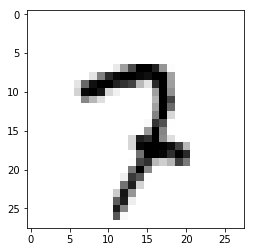

In [11]:
x, y = test[41]
plt.imshow(x.reshape(28,28),cmap='gray_r')

In [12]:
model.to_cpu()
pred = F.softmax(model.predictor(x.reshape(1, 784))).data
print("Prediction: "+str(np.argmax(pred)))
print("Answer: "+str(y))

InvalidType: 
Invalid operation is performed in: Convolution2DFunction (Forward)

Expect: in_types[0].ndim == 4
Actual: 2 != 4

In [ ]:
#chainer.serializers.save_npz("mymodel.npz", model)

In [ ]:
#model = L.Classifier(MLP(unit, n_out))
#chainer.serializers.load_npz("mymodel.npz", model)